# Capstone Project 2 - Rossmann Store Sales

## Exploratory Data Analysis 

We start with the Exploratory Data Analysis of the main metrics revealing present trends and patterns in the data to better understand our dataset.

In addition to using Prophet, I plan to explore the use one of the most robust and sophisticated algorithms - Extreme Gradient Boosting for regression.

### Import Necessary Modules

In [3]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

### Read Data

In [5]:
# importing train data to learn
train = pd.read_csv('train.csv', 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv('store.csv', 
                    low_memory = False)
# time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

### Exploratory Data Analysis

<li> this section will handle missing values and create new features for further analysis.

In [6]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(5).append(train.tail(5))

In total:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


#### Data Dictionary

- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. 
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

<li> Since we are dealing with time series data so it's a good idea to break up date into its individual components.
<li> Also, we can define a new feature, "sale per cusomer"

In [7]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

### [What is ECDF](https://en.wikipedia.org/wiki/Empirical_distribution_function)
<li>  ECDF value at any specified value of the measured variable is the fraction of observations of the measured variable that are less than or equal to the specified value.

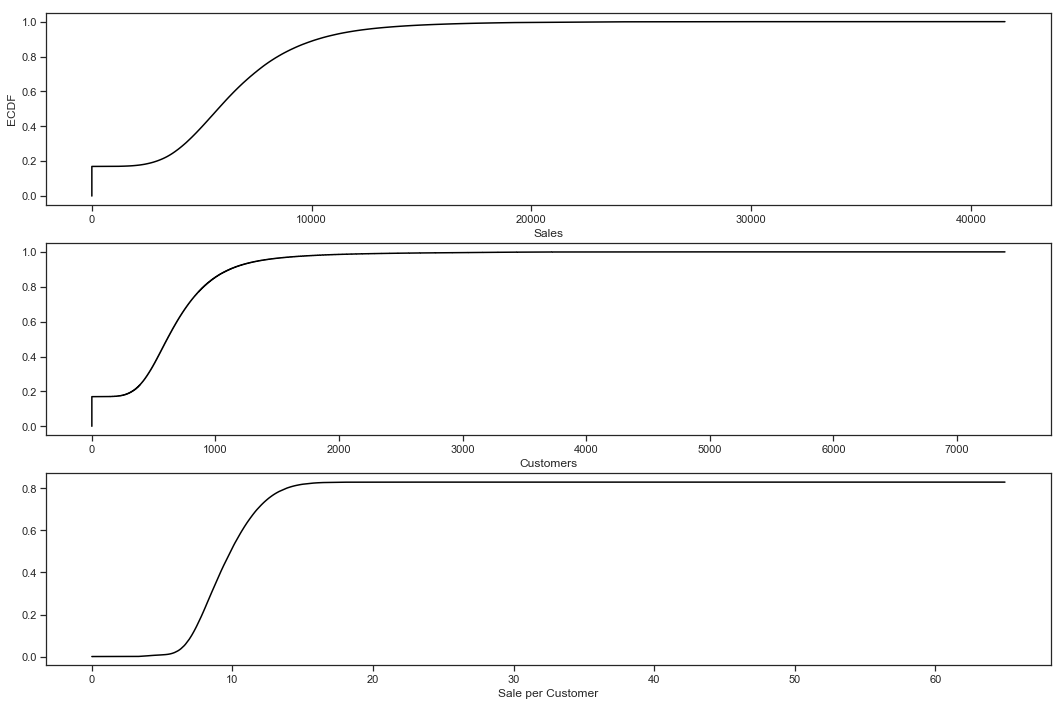

In [8]:
sns.set_context('poster')
sns.set(style = "ticks")# to format into seaborn 
c = 'black' # basic color for plots
plt.figure(figsize = (18, 12))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

<li> About 20% of data has zero amount of sales/customers that we need to deal with and almost 80% of time daily amount of sales was less than 1000. So what about zero sales, is it only due to the fact that the store is closed?

### Missing values 
#### Closed stores with zero sales

In [9]:
# closed stores
print('Number of closed stores: {0}'.format(len(train[(train.Open == 0) & (train.Sales == 0)])))

Number of closed stores: 172817


#### Open stores with zero sales

In [10]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print('Number of closed stores: {0}'.format(zero_sales.shape))
zero_sales.head(5)

Number of closed stores: (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


In [11]:
print("Closed stores and days with Zero sales won't be counted in the forecast.")

train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days with Zero sales won't be counted in the forecast.
In total:  (844338, 13)


#### Store Data Dictionary
- Store: a unique Id for each store
- StoreType: differentiates between 4 different store models: a, b, c, d
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance: distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
- Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [12]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

### Data Wrangling
#### CompetitionDistance

In [13]:
# missing values in CompetitionDistance
len(store[pd.isnull(store['CompetitionDistance'])])

3

In [14]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

#### Promo2SinceWeek

In [15]:
# no promo = no information about the promo?
a11 = store[pd.isnull(store.Promo2SinceWeek)]
a11[a11.Promo2 != 0].shape

(0, 10)

if there's no `Promo2` then there's no information about it and can be replaced by zero. 
The same is true for `CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear`.

In [16]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [17]:
# Join train and store by specifying inner join to ensure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)

In total:  (844338, 22)


### Store types

Now let's examine different `StoreType` and distribution of `Sales` across them.  

In [18]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


`StoreType` B has the highest average of Sales, albeit very little data compared to other stores. <br>
Let's print an the sum of `Sales` and `Customers` to see which `StoreType` is the most popular.

In [19]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum().sort_values(by='Sales', ascending=False)

,Customers,Sales
StoreType,,
a,363541431,3165334859
d,156904995,1765392943
c,92129705,783221426
b,31465616,159231395


Clearly A, and D stores lead in terms of `Sales` and `Customers`. <br>

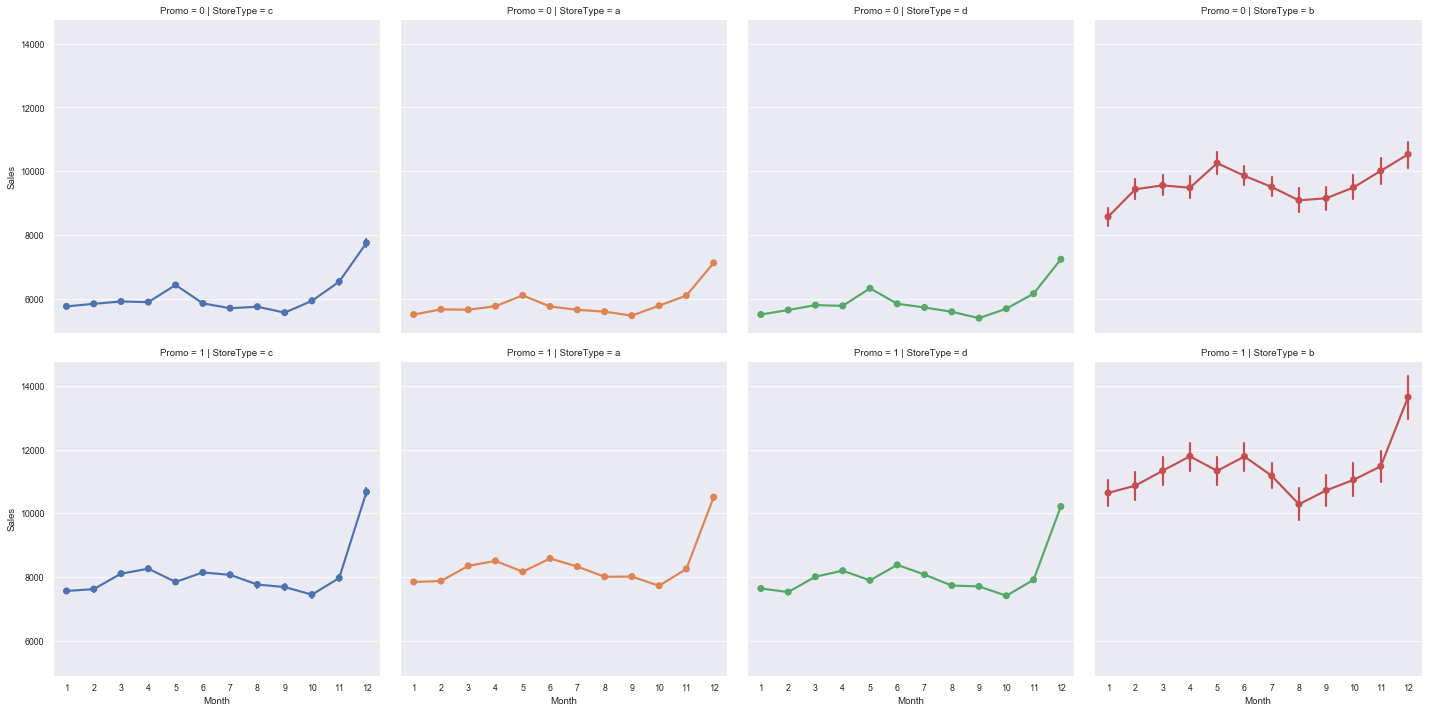

In [20]:
# sales trends
sns.set_style('darkgrid')
sns.set_context('paper')
_=sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'deep',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

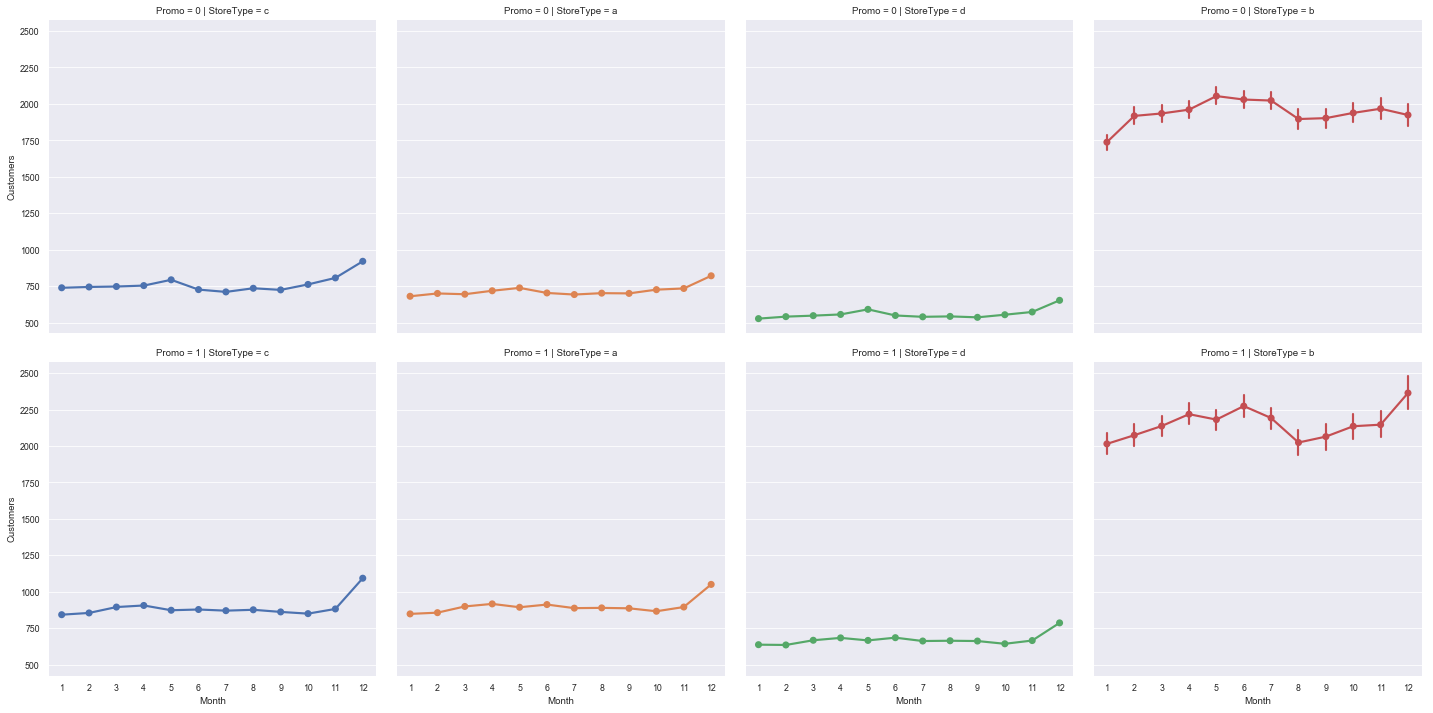

In [21]:
# customer trends
sns.set_style('darkgrid')
sns.set_context('paper')
_=sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'deep',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

All store types follow the same trend but at different scales depending on the presence of the (first) promotion `Promo` and `StoreType` itself (case for B).

_At this point, increasing Sales towards Christmas holidays is evident, but we'll talk about seasonaliy and trends later in the Time Series Analysis section._

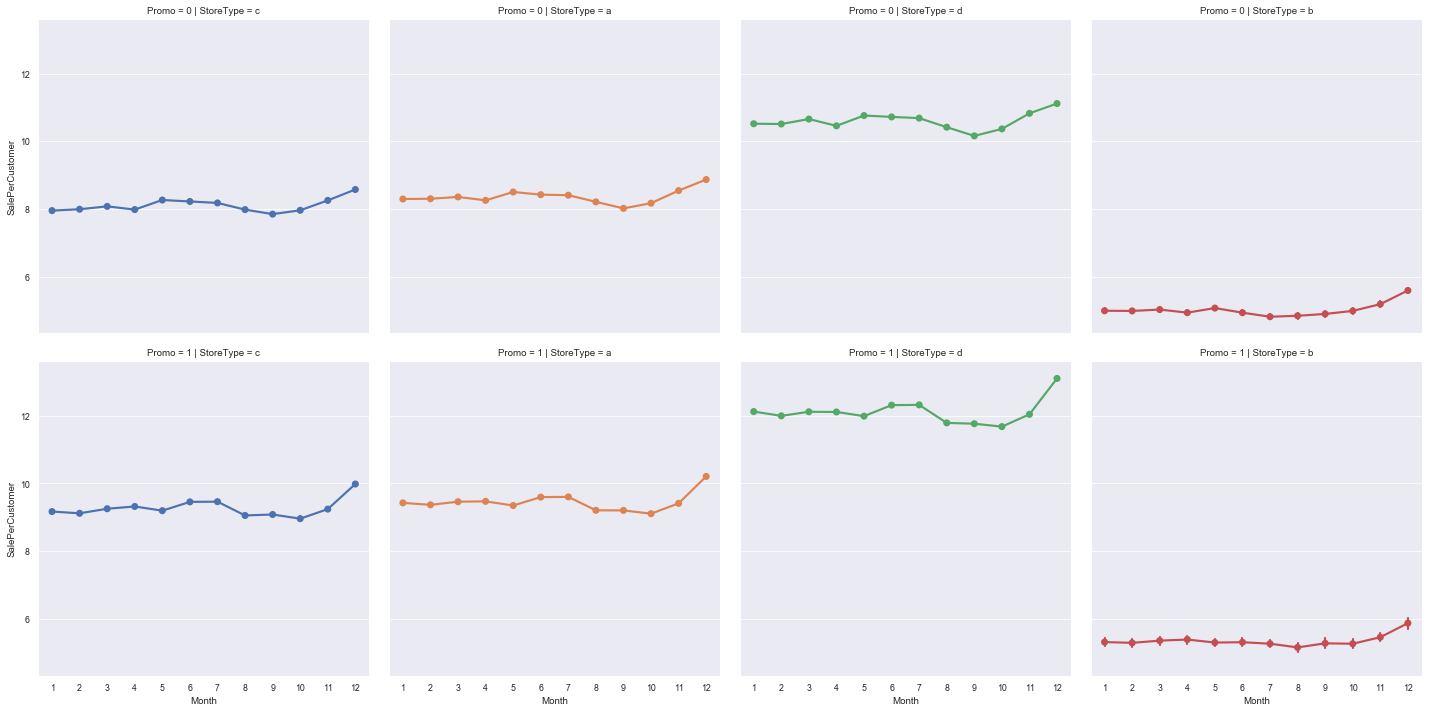

In [22]:
# sale per customer trends
sns.set_style('darkgrid')
sns.set_context('paper')
_=sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'deep',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

Even though the plots above showed `StoreType` B as the most popular, though in reality that is not true. The highest `SalePerCustomer` amount is observed at the `StoreType` D, ~ 12€ with `Promo` and ~ 10€ without a promo, and for `StoreType` A and C it is about 9€. <br>
Based on low `SalePerCustomer` amount for `StoreType` B, we can attempt to describe the Cart: there are a lot of people who shop essentially for **small** things (or in a little quantity).

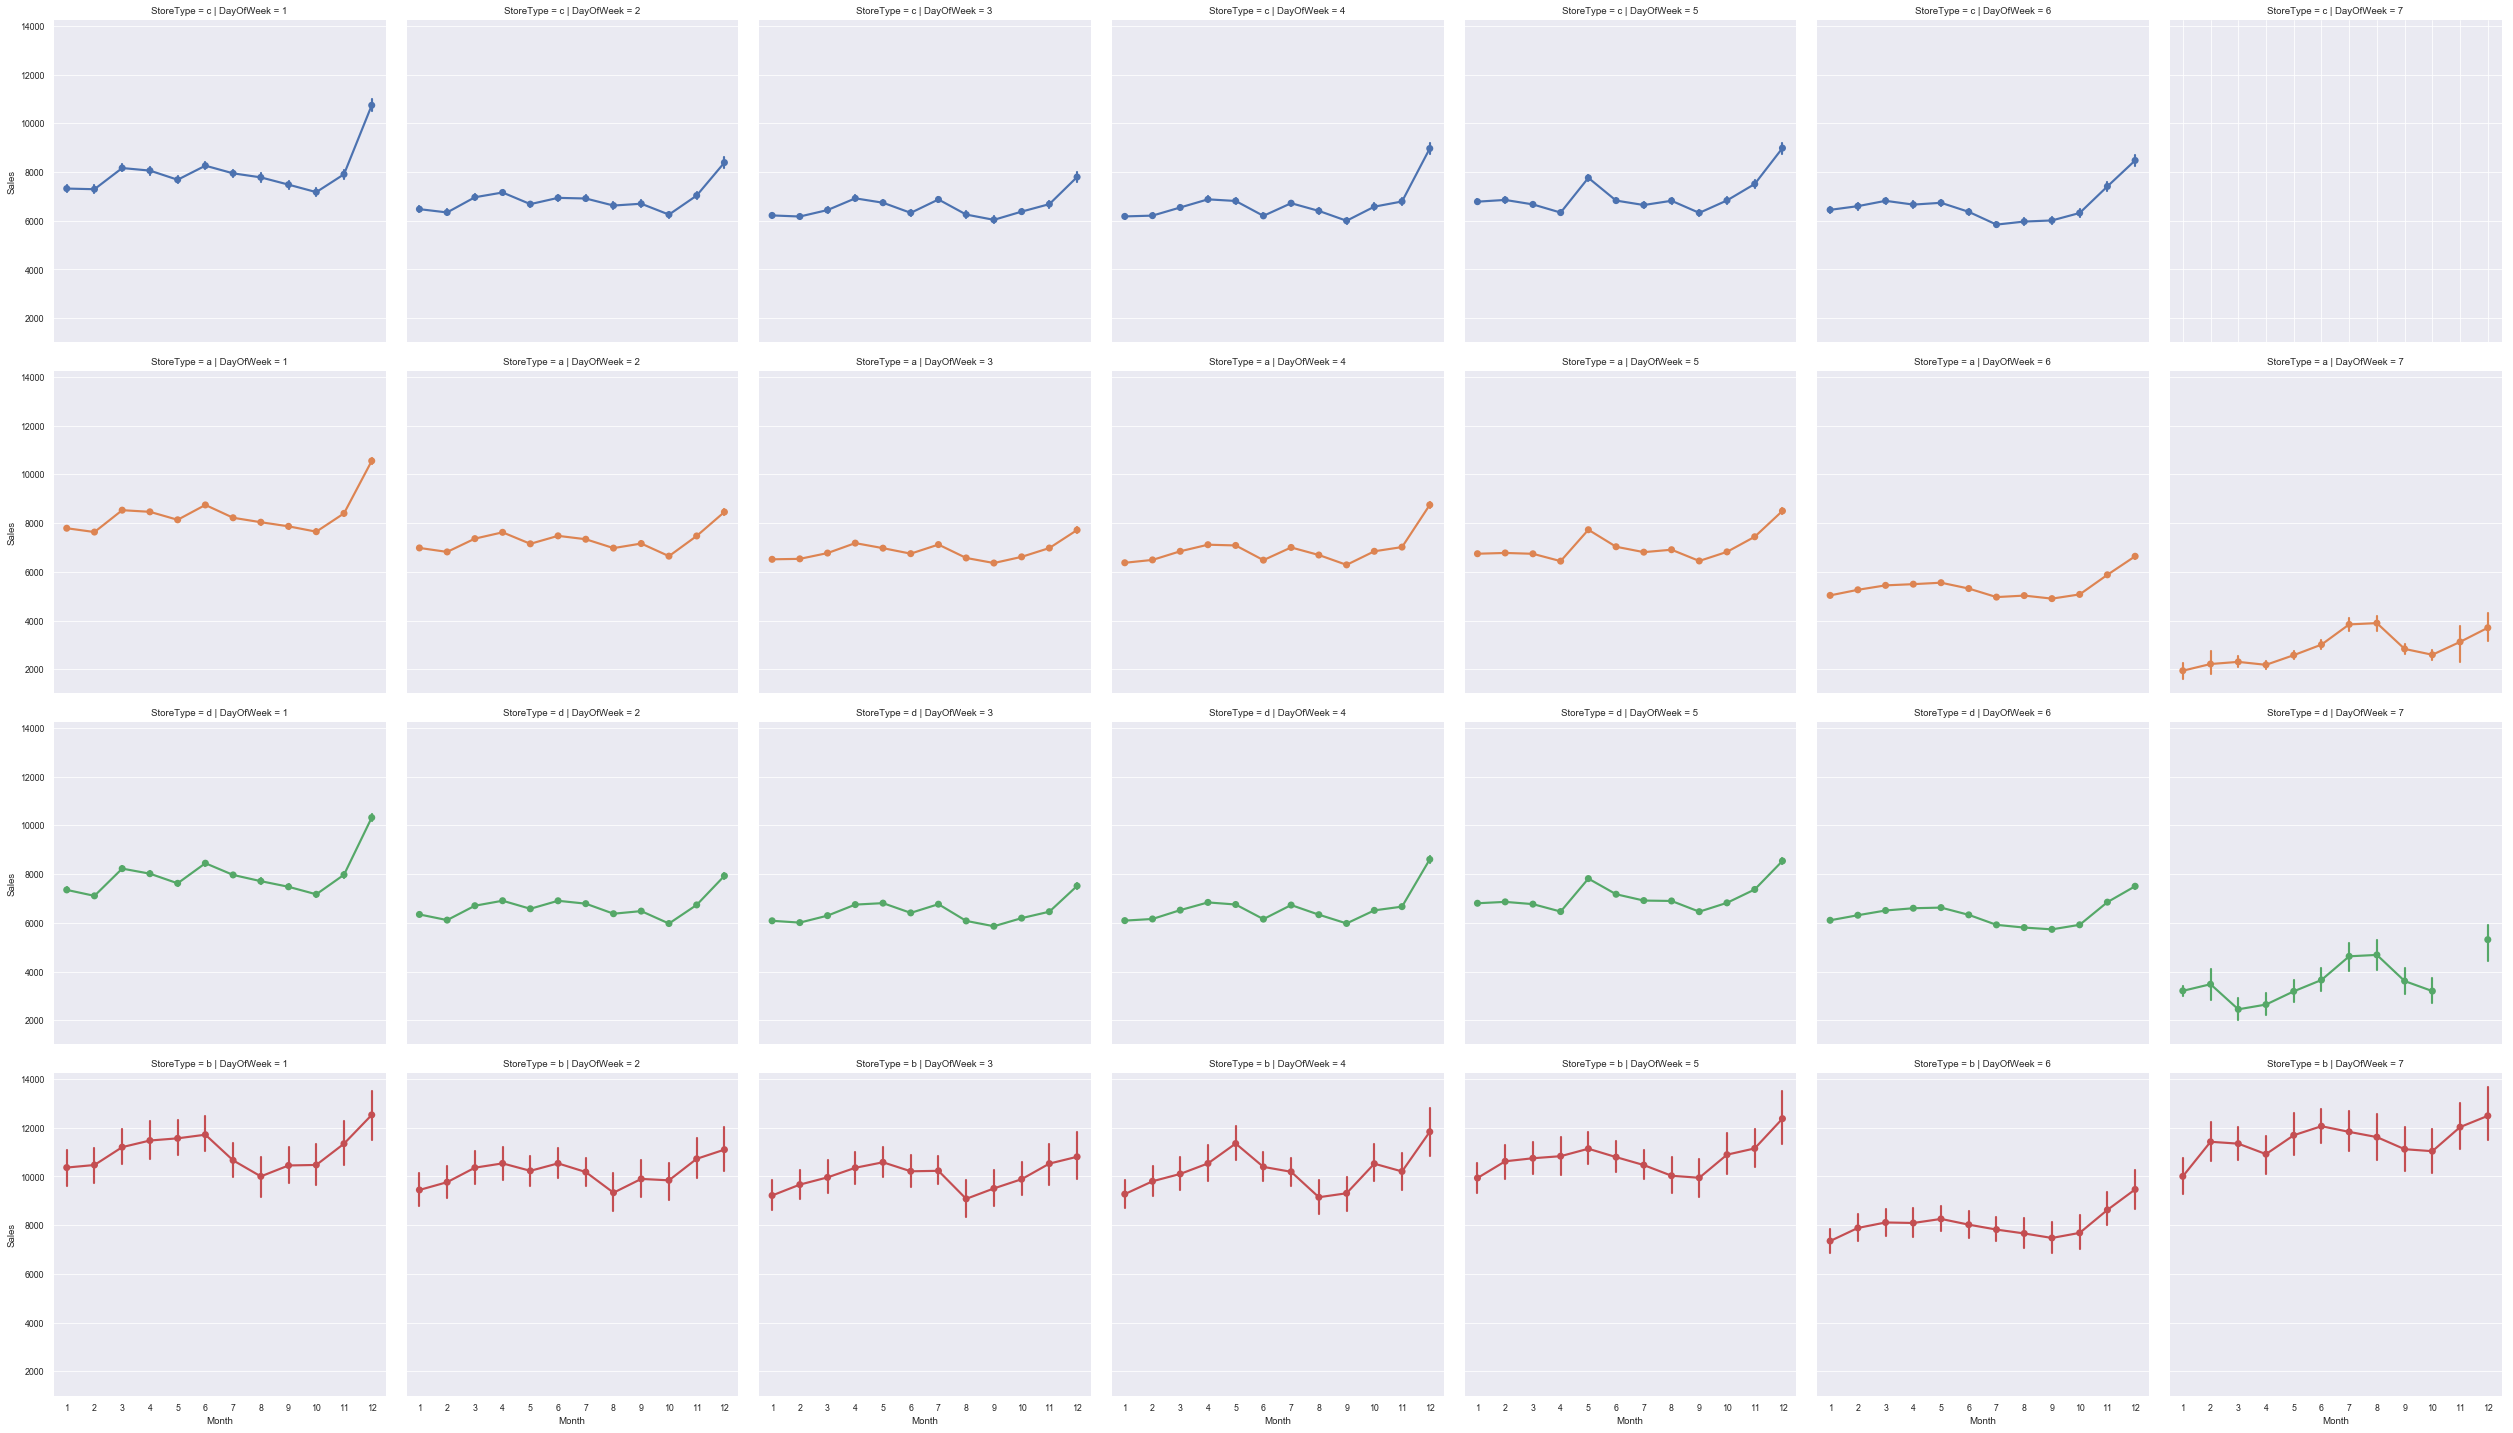

In [23]:
# customers
sns.set_style('darkgrid')
sns.set_context('paper')
_=sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'deep',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c) 

We see that stores of `StoreType` C are closed on Sundays, whereas others are open. Interestingly enough, stores of `StoreType` D are closed on Sundays only from October to December.

By the way which stores which are open on Sundays?

In [24]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])

In [25]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean().sort_values(by='Sales', ascending=False)

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
a,6925.697986,795.422370,12918.492198,7115.514452
d,6822.300064,606.353935,10421.916846,9028.526526


`StoreType` B, has the longest running period of promotion.

### Correlational Analysis

We are finished with adding new variables to the data, so now we can check the overall correlations by plotting the `seaborn` heatmap:

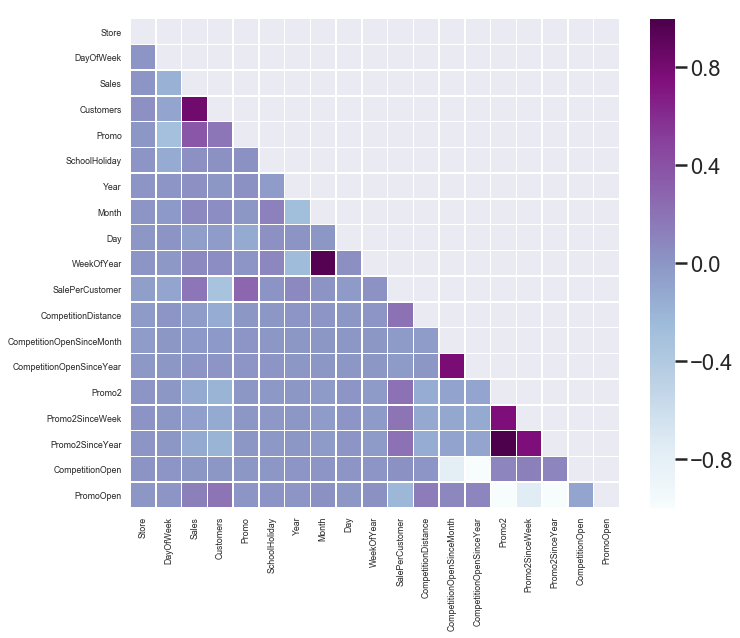

In [26]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.set_context('poster')
sns.set_style('darkgrid')
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

We can identify a positive correlation between the amount of Sales and Customers of a store.<br>
We can also observe a positive correlation between the fact that the store had a running promotion (`Promo` equal to 1) and amount of `Customers`.  <br>
Interestingly enough though, as soon as a store has consecutive promotions (`Promo2` equal to 1) the number of `Customers` and `Sales` seems to stay steady or even decrease, which is described by the pale negative correlation on the heatmap. <br>
The same negative correlation is observed between the presence of the promotion in the store and the day of a week.

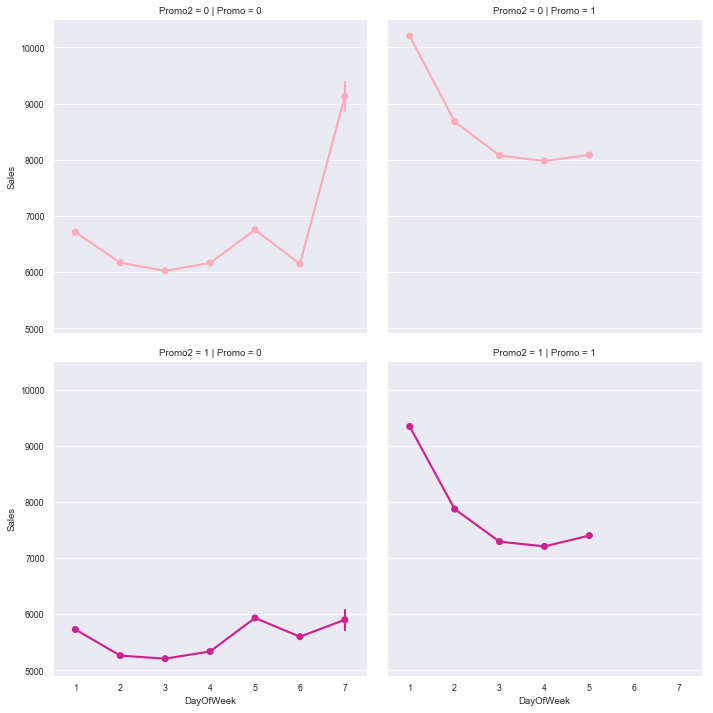

In [27]:
# sale per customer trends
sns.set_context('paper')
sns.set_style('darkgrid')
_=sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

Few things to be noted from above <br>
In case of no active promotion, both `Promo` and `Promo2` equal to 0, `Sales` tend to peak on Sunday. Though we should note that `StoreType` C doesn't work on Sundays.<br>
On the contrary, stores that run the promotion tend to make most of the `Sales` on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (`Promo` and `Promo2` are equal to 1). <br>
`Promo2` alone doesn't seem to be correlated to any significant change in the `Sales` amount. <br>

## Summary of EDA

The `StoreType` is A is most crowded with highest sales.<br>
`StoreType` D with highest "**Sale per Customer**"  indicates a strong Buyer Cart. An interesting thing to do will be to map these stores on the map to check whether they are urban or rural locations.<br>
Low `SalePerCustomer` amount for `StoreType` B alludes to the possibility that people are essentially shopping for sundry items. An interesting thing to do will be to map these stores on the map to check whether they are urban or rural locations and compare it against locations from point 2. <br>
Customers tends to buy more on Mondays when there's a single promotion running (`Promo`) and on Sundays when there is no promotion at all (both `Promo` and `Promo1` are equal to 0).<br> 

My goal is now to create a model which predicts 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation.